#### loading the libraries

In [7]:
import os
import sys
import pyvista as pv
import trimesh as tm
import numpy as np
import topogenesis as tg
import pickle as pk
import matplotlib.pyplot as plt
sys.path.append(os.path.realpath('..\..')) # no idea how or why this is not working without adding this to the path TODO: learn about path etc.
from notebooks.resources import RES as res
from pygmo import *
import pygmo as pg

#### loading the meshes and vectors

In [8]:
# load base lattice CSV file
lattice_path = os.path.relpath('../../data/macrovoxels.csv')
macro_lattice = tg.lattice_from_csv(lattice_path)

# load environment
environment_path = os.path.relpath("../../data/movedcontext.obj") 
environment_mesh = tm.load(environment_path)

# load solar vectors
vectors = pk.load(open("../../data/sunvectors.pk", "rb"))

# load vector intensities
intensity_pv = pk.load(open("../../data/ghrval.pk", "rb")) # global horizontal radiation

# load vector intensities
intensity_dl = pk.load(open("../../data/dnival.pk", "rb")) # direct normal illuminance

#### defining target FSI, number of variables

In [9]:
goal_FSI = 3
num_var = macro_lattice.flatten().shape[0]

#### creating the class for running the optimization

In [10]:
class pygmo_optimize:

    # Number of dimensions
    def __init__(self, dim, reflattice, crit1_values, crit2_values, sunvectors, environment, targetFSI):
        self.dim = dim
        self.reflattice = reflattice
        self.crit1_values = crit1_values
        self.crit2_values = crit2_values
        self.sunvectors = sunvectors
        self.environment = environment
        self.targetFSI = targetFSI

    # Define objectives    
    def fitness(self, x):
        # PyGmo minimizes. To maximize, we need to invert our objective functions

        # global horizontal radiation on voxel roofs (PV potential) MAXIMIZE
        f1 = - res.crit_1_PV(x, self.reflattice, self.sunvectors, self.crit1_values, self.environment)[0]

        # direct normal illuminance on voxel facade (daylight potential) MAXIMIZE
        f2 = - res.crit_2_DL(x, self.reflattice, self.sunvectors, self.crit2_values, self.environment)[0]

        # relative compactness MINIMIZE
        f3 =   res.crit_3_RC(x, self.reflattice)

        # Floor Space Index deviation MAXIMIZE
        f4 = - res.crit_4_FSI(x, self.reflattice, self.targetFSI)

        return [f1, f2, f3, f4]
    
    # Return number of objectives
    def get_nobj(self):
        return 4

    # Return bounds of decision variables
    def get_bounds(self):
        return (np.full((self.dim,),0.),np.full((self.dim,),1.))

    # Return function name
    def get_name(self):
        return "Test function MAX"

In [11]:
# create User Defined Problem
prob = pg.problem(pygmo_optimize(
    dim= num_var, 
    reflattice= macro_lattice, 
    crit1_values= intensity_pv, 
    crit2_values= intensity_dl, 
    sunvectors= vectors, 
    environment= environment_mesh, 
    targetFSI= goal_FSI
    ))

#### the setup

In [12]:
pop_sizes=[16, 32]

udp = prob

hv_nspso=[0, 0]

hv_ihs=[0, 0]

hv_nsga2=[0, 0]

p_dist_nspso=[0, 0]

p_dist_ihs=[0, 0]

p_dist_nsga2=[0, 0]

In [13]:
#We run the algos three times each, for 3 different pop-sizes

for j in pop_sizes:

      for i in range(0,3):

             pop_1 = pg.population(prob = udp, size = j, seed = i)

             pop_2 = pg.population(prob = udp, size = j, seed = i)

             pop_3 = pg.population(prob = udp, size = j, seed = i)


             #1st seed:

             if j==pop_sizes[0] and i==0:

                 first_pop_low_1=pop_1.get_f()

             if j==pop_sizes[1] and i==0:

                 first_pop_high_1=pop_1.get_f()


             #2nd seed:

             if j==pop_sizes[0] and i==1:

                 first_pop_low_2=pop_1.get_f()

             if j==pop_sizes[1] and i==1:

                 first_pop_high_2=pop_1.get_f()


             #3rd seed:

             if j==pop_sizes[0] and i==2:

                 first_pop_low_3=pop_1.get_f()

             if j==pop_sizes[1] and i==2:

                 first_pop_high_3=pop_1.get_f()


             algo = pg.algorithm(pg.nspso(gen = 3))

             algo_2 = pg.algorithm(pg.ihs(gen = 3))

             algo_3 = pg.algorithm(pg.nsga2(gen = 3))

             algo.set_seed(i+1)

             algo_2.set_seed(i+1)

             algo_3.set_seed(i+1)

             pop_1 = algo.evolve(pop_1)

             pop_2= algo_2.evolve(pop_2)

             pop_3 = algo_3.evolve(pop_3)


             #This returns a series of arrays: in each of them it is contained (in this order), the -non-dominated front, -domination list,

             #-domination count, -non-domination rank

             fnds= pg.fast_non_dominated_sorting(pop_1.get_f())

             fnds_2= pg.fast_non_dominated_sorting(pop_2.get_f())

             fnds_3= pg.fast_non_dominated_sorting(pop_3.get_f())


             #This returns the first (i.e., best) non-dominated front:

             first_ndf_nspso=fnds[0][0]

             first_ndf_ihs=fnds_2[0][0]

             first_ndf_nsga2=fnds_3[0][0]


             #I store all the pop-sizes non-dominated fronts for all the runs:

             #1st seed:

             if j==pop_sizes[0] and i==0:

                 #MOEA/D

                 #hv_nspso[0]= pg.hypervolume(pop_1).compute(ref_point)

                 #p_dist_nspso[0]=udp.p_distance(pop_1)

                 first_col_nspso_poplow_1=pop_1.get_f()[first_ndf_nspso,0]

                 second_col_nspso_poplow_1=pop_1.get_f()[first_ndf_nspso,1]

                 third_col_nspso_poplow_1=pop_1.get_f()[first_ndf_nspso,2]

                 fourth_col_nspso_poplow_1=pop_1.get_f()[first_ndf_nspso,3]

                 #ihs

                 #hv_ihs[0]= pg.hypervolume(pop_2).compute(ref_point)

                 #p_dist_ihs[0]=udp.p_distance(pop_2)

                 first_col_ihs_poplow_1=pop_2.get_f()[first_ndf_ihs,0]

                 second_col_ihs_poplow_1=pop_2.get_f()[first_ndf_ihs,1]

                 third_col_ihs_poplow_1=pop_2.get_f()[first_ndf_ihs,2]

                 fourth_col_ihs_poplow_1=pop_2.get_f()[first_ndf_ihs,3]

                 #NSGA2

                 #hv_nsga2[0]= pg.hypervolume(pop_3).compute(ref_point)

                 #p_dist_nsga2[0]=udp.p_distance(pop_3)

                 first_col_nsga2_poplow_1=pop_3.get_f()[first_ndf_nsga2,0]

                 second_col_nsga2_poplow_1=pop_3.get_f()[first_ndf_nsga2,1]

                 first_col_nsga2_poplow_1=pop_3.get_f()[first_ndf_nsga2,2]

                 fourth_col_nsga2_poplow_1=pop_3.get_f()[first_ndf_nsga2,3]


             if j==pop_sizes[1] and i==0:

                 #MOEA/D

                 #hv_nspso[1]= pg.hypervolume(pop_1).compute(ref_point)

                 #p_dist_nspso[1]=udp.p_distance(pop_1)

                 first_col_nspso_pophigh_1=pop_1.get_f()[first_ndf_nspso,0]

                 second_col_nspso_pophigh_1=pop_1.get_f()[first_ndf_nspso,1]

                 third_col_nspso_pophigh_1=pop_1.get_f()[first_ndf_nspso,2]

                 fourth_col_nspso_pophigh_1=pop_1.get_f()[first_ndf_nspso,3]

                 #ihs

                 #hv_ihs[1]= pg.hypervolume(pop_2).compute(ref_point)

                 #p_dist_ihs[1]=udp.p_distance(pop_2)

                 first_col_ihs_pophigh_1=pop_2.get_f()[first_ndf_ihs,0]

                 second_col_ihs_pophigh_1=pop_2.get_f()[first_ndf_ihs,1]

                 third_col_ihs_pophigh_1=pop_2.get_f()[first_ndf_ihs,2]

                 fourth_col_ihs_pophigh_1=pop_2.get_f()[first_ndf_ihs,3]

                 #NSGA2

                 #hv_nsga2[1]= pg.hypervolume(pop_3).compute(ref_point)

                 #p_dist_nsga2[1]=udp.p_distance(pop_3)

                 first_col_nsga2_pophigh_1=pop_3.get_f()[first_ndf_nsga2,0]

                 second_col_nsga2_pophigh_1=pop_3.get_f()[first_ndf_nsga2,1]

                 third_col_nsga2_pophigh_1=pop_3.get_f()[first_ndf_nsga2,2]

                 fourth_col_nsga2_pophigh_1=pop_3.get_f()[first_ndf_nsga2,3]



             #2nd seed:

             if j==pop_sizes[0] and i==1:

                 #MOEA/D

                 #hv_nspso[0]+= pg.hypervolume(pop_1).compute(ref_point)

                 #p_dist_nspso[0]+=udp.p_distance(pop_1)

                 first_col_nspso_poplow_2=pop_1.get_f()[first_ndf_nspso,0]

                 second_col_nspso_poplow_2=pop_1.get_f()[first_ndf_nspso,1]

                 third_col_nspso_poplow_2=pop_1.get_f()[first_ndf_nspso,2]

                 fourth_col_nspso_poplow_2=pop_1.get_f()[first_ndf_nspso,3]

                 #ihs

                 #hv_ihs[0]+= pg.hypervolume(pop_2).compute(ref_point)

                 #p_dist_ihs[0]+=udp.p_distance(pop_2)

                 first_col_ihs_poplow_2=pop_2.get_f()[first_ndf_ihs,0]

                 second_col_ihs_poplow_2=pop_2.get_f()[first_ndf_ihs,1]

                 third_col_ihs_poplow_2=pop_2.get_f()[first_ndf_ihs,2]

                 fourth_col_ihs_poplow_2=pop_2.get_f()[first_ndf_ihs,3]

                 #NSGA2

                 #hv_nsga2[0]+= pg.hypervolume(pop_3).compute(ref_point)

                 #p_dist_nsga2[0]+=udp.p_distance(pop_3)

                 first_col_nsga2_poplow_2=pop_3.get_f()[first_ndf_nsga2,0]

                 second_col_nsga2_poplow_2=pop_3.get_f()[first_ndf_nsga2,1]

                 third_col_nsga2_poplow_2=pop_3.get_f()[first_ndf_nsga2,2]

                 fourth_col_nsga2_poplow_2=pop_3.get_f()[first_ndf_nsga2,3]


             if j==pop_sizes[1] and i==1:

                 #MOEA/D

                 #hv_nspso[1]+= pg.hypervolume(pop_1).compute(ref_point)

                 #p_dist_nspso[1]+=udp.p_distance(pop_1)

                 first_col_nspso_pophigh_2=pop_1.get_f()[first_ndf_nspso,0]

                 second_col_nspso_pophigh_2=pop_1.get_f()[first_ndf_nspso,1]

                 third_col_nspso_pophigh_2=pop_1.get_f()[first_ndf_nspso,2]

                 fourth_col_nspso_pophigh_2=pop_1.get_f()[first_ndf_nspso,3]

                 #ihs

                 #hv_ihs[1]+= pg.hypervolume(pop_2).compute(ref_point)

                 #p_dist_ihs[1]+=udp.p_distance(pop_2)

                 first_col_ihs_pophigh_2=pop_2.get_f()[first_ndf_ihs,0]

                 second_col_ihs_pophigh_2=pop_2.get_f()[first_ndf_ihs,1]

                 third_col_ihs_pophigh_2=pop_2.get_f()[first_ndf_ihs,2]

                 fourth_col_ihs_pophigh_2=pop_2.get_f()[first_ndf_ihs,3]

                 #NSGA2

                 #hv_nsga2[1]+= pg.hypervolume(pop_3).compute(ref_point)

                 #p_dist_nsga2[1]+=udp.p_distance(pop_3)

                 first_col_nsga2_pophigh_2=pop_3.get_f()[first_ndf_nsga2,0]

                 second_col_nsga2_pophigh_2=pop_3.get_f()[first_ndf_nsga2,1]

                 third_col_nsga2_pophigh_2=pop_3.get_f()[first_ndf_nsga2,2]

                 fourth_col_nsga2_pophigh_2=pop_3.get_f()[first_ndf_nsga2,3]



             #3rd seed:

             if j==pop_sizes[0] and i==2:

                 #MOEA/D

                 #hv_nspso[0]+= pg.hypervolume(pop_1).compute(ref_point)

                 #p_dist_nspso[0]+=udp.p_distance(pop_1)

                 first_col_nspso_poplow_3=pop_1.get_f()[first_ndf_nspso,0]

                 second_col_nspso_poplow_3=pop_1.get_f()[first_ndf_nspso,1]

                 third_col_nspso_poplow_3=pop_1.get_f()[first_ndf_nspso,2]

                 fourth_col_nspso_poplow_3=pop_1.get_f()[first_ndf_nspso,3]

                 #ihs

                 #hv_ihs[0]+= pg.hypervolume(pop_2).compute(ref_point)

                 #p_dist_ihs[0]+=udp.p_distance(pop_2)

                 first_col_ihs_poplow_3=pop_2.get_f()[first_ndf_ihs,0]

                 second_col_ihs_poplow_3=pop_2.get_f()[first_ndf_ihs,1]

                 third_col_ihs_poplow_3=pop_2.get_f()[first_ndf_ihs,2]

                 fourth_col_ihs_poplow_3=pop_2.get_f()[first_ndf_ihs,3]

                 #NSGA2

                 #hv_nsga2[0]+= pg.hypervolume(pop_3).compute(ref_point)

                 #p_dist_nsga2[0]+=udp.p_distance(pop_3)

                 first_col_nsga2_poplow_3=pop_3.get_f()[first_ndf_nsga2,0]

                 second_col_nsga2_poplow_3=pop_3.get_f()[first_ndf_nsga2,1]

                 third_col_nsga2_poplow_3=pop_3.get_f()[first_ndf_nsga2,2]

                 fourth_col_nsga2_poplow_3=pop_3.get_f()[first_ndf_nsga2,3]


             if j==pop_sizes[1] and i==2:

                 #MOEA/D

                 #hv_nspso[1]+= pg.hypervolume(pop_1).compute(ref_point)

                 #p_dist_nspso[1]+=udp.p_distance(pop_1)

                 first_col_nspso_pophigh_3=pop_1.get_f()[first_ndf_nspso,0]

                 second_col_nspso_pophigh_3=pop_1.get_f()[first_ndf_nspso,1]

                 third_col_nspso_pophigh_3=pop_1.get_f()[first_ndf_nspso,2]

                 fourth_col_nspso_pophigh_3=pop_1.get_f()[first_ndf_nspso,3]

                 #ihs

                 #hv_ihs[1]+= pg.hypervolume(pop_2).compute(ref_point)

                 #p_dist_ihs[1]+=udp.p_distance(pop_2)

                 first_col_ihs_pophigh_3=pop_2.get_f()[first_ndf_ihs,0]

                 second_col_ihs_pophigh_3=pop_2.get_f()[first_ndf_ihs,1]

                 third_col_ihs_pophigh_3=pop_2.get_f()[first_ndf_ihs,2]

                 fourth_col_ihs_pophigh_3=pop_2.get_f()[first_ndf_ihs,3]

                 #NSGA2

                 #hv_nsga2[1]+= pg.hypervolume(pop_3).compute(ref_point)

                 #p_dist_nsga2[1]+=udp.p_distance(pop_3)

                 first_col_nsga2_pophigh_3=pop_3.get_f()[first_ndf_nsga2,0]

                 second_col_nsga2_pophigh_3=pop_3.get_f()[first_ndf_nsga2,1]

                 third_col_nsga2_pophigh_3=pop_3.get_f()[first_ndf_nsga2,2]

                 fourth_col_nsga2_pophigh_3=pop_3.get_f()[first_ndf_nsga2,3]



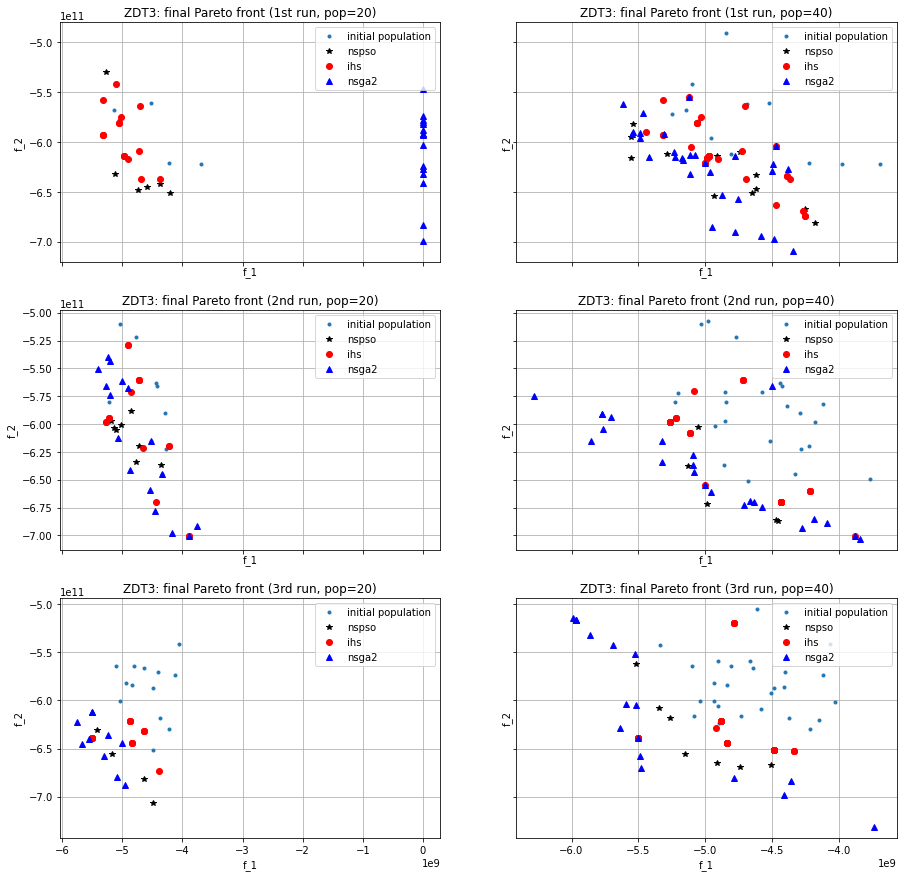

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='row', figsize=(15,15)) 

axes[0,0].plot(first_pop_low_1[:,0], first_pop_low_1[:,1], '.', label= 'initial population') 

axes[0,0].plot(first_col_nspso_poplow_1, second_col_nspso_poplow_1,'k*', label = 'nspso') 

axes[0,0].plot(first_col_ihs_poplow_1, second_col_ihs_poplow_1,'ro', label = 'ihs') 

axes[0,0].plot(first_col_nsga2_poplow_1, second_col_nsga2_poplow_1, 'b^', label = 'nsga2') 

axes[0,0].legend(loc='upper right') 

axes[0,0].set_title('ZDT3: final Pareto front (1st run, pop=20)') 

axes[0,1].plot(first_pop_high_1[:,0], first_pop_high_1[:,1], '.', label= 'initial population') 

axes[0,1].plot(first_col_nspso_pophigh_1, second_col_nspso_pophigh_1,'k*', label = 'nspso') 

axes[0,1].plot(first_col_ihs_pophigh_1, second_col_ihs_pophigh_1,'ro', label = 'ihs') 

axes[0,1].plot(first_col_nsga2_pophigh_1, second_col_nsga2_pophigh_1, 'b^', label = 'nsga2') 

axes[0,1].legend(loc='upper right') 

axes[0,1].set_title('ZDT3: final Pareto front (1st run, pop=40)') 



axes[1,0].plot(first_pop_low_2[:,0], first_pop_low_2[:,1], '.', label= 'initial population') 

axes[1,0].plot(first_col_nspso_poplow_2, second_col_nspso_poplow_2,'k*', label = 'nspso') 

axes[1,0].plot(first_col_ihs_poplow_2, second_col_ihs_poplow_2,'ro', label = 'ihs') 

axes[1,0].plot(first_col_nsga2_poplow_2, second_col_nsga2_poplow_2, 'b^', label = 'nsga2') 

axes[1,0].legend(loc='upper right') 

axes[1,0].set_title('ZDT3: final Pareto front (2nd run, pop=20)') 

axes[1,1].plot(first_pop_high_2[:,0], first_pop_high_2[:,1], '.', label= 'initial population') 

axes[1,1].plot(first_col_nspso_pophigh_2, second_col_nspso_pophigh_2,'k*', label = 'nspso') 

axes[1,1].plot(first_col_ihs_pophigh_2, second_col_ihs_pophigh_2,'ro', label = 'ihs') 

axes[1,1].plot(first_col_nsga2_pophigh_2, second_col_nsga2_pophigh_2, 'b^', label = 'nsga2') 

axes[1,1].legend(loc='upper right') 

axes[1,1].set_title('ZDT3: final Pareto front (2nd run, pop=40)') 



axes[2,0].plot(first_pop_low_3[:,0], first_pop_low_3[:,1], '.', label= 'initial population') 

axes[2,0].plot(first_col_nspso_poplow_3, second_col_nspso_poplow_3,'k*', label = 'nspso') 

axes[2,0].plot(first_col_ihs_poplow_3, second_col_ihs_poplow_3,'ro', label = 'ihs') 

axes[2,0].plot(first_col_nsga2_poplow_3, second_col_nsga2_poplow_3, 'b^', label = 'nsga2') 

axes[2,0].legend(loc='upper right') 

axes[2,0].set_title('ZDT3: final Pareto front (3rd run, pop=20)') 

axes[2,1].plot(first_pop_high_3[:,0], first_pop_high_3[:,1], '.', label= 'initial population') 

axes[2,1].plot(first_col_nspso_pophigh_3, second_col_nspso_pophigh_3,'k*', label = 'nspso') 

axes[2,1].plot(first_col_ihs_pophigh_3, second_col_ihs_pophigh_3,'ro', label = 'ihs') 

axes[2,1].plot(first_col_nsga2_pophigh_3, second_col_nsga2_pophigh_3, 'b^', label = 'nsga2') 

axes[2,1].legend(loc='upper right') 

axes[2,1].set_title('ZDT3: final Pareto front (3rd run, pop=40)') 

for ax in axes.flat: 

   ax.set(xlabel='f_1', ylabel='f_2') 

   ax.grid() 